In [72]:
import copy
import time
from pathlib import Path

import torch
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from cuticulus.datasets import RoughSmoothFull
from cuticulus.console import console

In [73]:
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

In [74]:
if not Path('output').exists():
    Path('output').mkdir(parents=True)

In [75]:
def cutmix(batch, alpha):
    data, targets = batch

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    targets = np.array([targets, shuffled_targets, lam])

    return data, targets

In [76]:
class CutMixCollator:
    def __init__(self, alpha):
        self.alpha = alpha

    def __call__(self, batch):
        batch = torch.utils.data.dataloader.default_collate(batch)
        batch = cutmix(batch, self.alpha)
        return batch

In [77]:
class CutMixCriterion:
    def __init__(self, reduction):
        self.criterion = torch.nn.CrossEntropyLoss(reduction=reduction)

    def __call__(self, preds, targets):
        targets1, targets2, lam = targets
        return lam * self.criterion(
            preds, targets1) + (1 - lam) * self.criterion(preds, targets2)

In [78]:
class TorchDS(torch.utils.data.Dataset):
    """Torch dataset class for ant image dataset."""

    def __init__(self, imgs: np.ndarray, labels: np.ndarray):
        """Initialize dataset.

        Args:
            imgs (np.ndarray): List of data.
            labels (np.ndarray): List of labels.
        """
        self.imgs = imgs
        self.labels = labels

    def __len__(self) -> int:
        """Return length of dataset.

        Returns:
            int: Length of dataset.
        """
        return len(self.imgs)

    def __getitem__(self, idx) -> tuple:
        """Return item at index idx.

        Returns:
            tuple: Tuple of image and label.
        """
        return self.imgs[idx], self.labels[idx]

In [79]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    history = {
        'train_loss': [],
        'train_acc': [], 
        'val_loss': [],
        'val_acc': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['train_acc'].append(epoch_acc)
                history['train_loss'].append(epoch_loss)
            elif phase == 'val':
                history['val_acc'].append(epoch_acc)
                history['val_loss'].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [80]:
torch.cuda.is_available()

True

In [81]:
ds = RoughSmoothFull((256, 256))

[10:47:39] Loaded labels.                                                       ]8;id=429835;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=909909;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#89\89]8;;\

           Loaded dataset.                                                     ]8;id=929610;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=79468;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#114\114]8;;\

           Unique images considered: 2499                                      ]8;id=438688;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=282162;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#135\135]8;;\

           Samples per class:                                                  ]8;id=499447;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=75944;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 1072                                                             ]8;id=143386;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=607293;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 1427                                                             ]8;id=948485;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=111507;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

In [82]:
# torch expects images to be in format (batch, channels, height, width)
ds.images = ds.images.transpose(0, 3, 1, 2)
print(ds.images.shape, ds.labels.shape)

# convert to float
ds.images = ds.images.astype(np.float32)
print(ds.images.dtype, ds.labels.dtype)

# split into train, test, and validation
ds.stratified_split(n_samples=800)
ds.split_validation()

train_images, train_labels = ds.train()
test_images, test_labels = ds.test()
val_images, val_labels = ds.validate()

(2499, 3, 256, 256) (2499,)
float32 int64


[10:47:40] After splitting train and test:                                     ]8;id=497588;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py\splitter.py]8;;\:]8;id=352774;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py#60\60]8;;\

           Training set:                                                       ]8;id=304594;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py\splitter.py]8;;\:]8;id=612241;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py#72\72]8;;\

[10:47:41] Samples per class:                                                  ]8;id=617702;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=753219;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 800                                                              ]8;id=835183;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=234715;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 800                                                              ]8;id=448665;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=17133;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           Testing set:                                                        ]8;id=836018;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py\splitter.py]8;;\:]8;id=184447;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py#76\76]8;;\

           Samples per class:                                                  ]8;id=874451;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=531124;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 272                                                              ]8;id=946400;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=281406;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 627                                                              ]8;id=967527;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=130537;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           After splitting validation:                                        ]8;id=70164;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py\splitter.py]8;;\:]8;id=190213;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py#108\108]8;;\

           Training set:                                                       ]8;id=497441;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py\splitter.py]8;;\:]8;id=336822;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py#72\72]8;;\

           Samples per class:                                                  ]8;id=604674;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=242360;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 800                                                              ]8;id=741532;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=313116;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 800                                                              ]8;id=310369;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=957232;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           Testing set:                                                        ]8;id=832025;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py\splitter.py]8;;\:]8;id=751222;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py#76\76]8;;\

           Samples per class:                                                  ]8;id=225026;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=364870;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

[10:47:42] 0: 138                                                              ]8;id=437223;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=737884;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 312                                                              ]8;id=63047;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=208229;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           Validation set:                                                     ]8;id=361970;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py\splitter.py]8;;\:]8;id=180362;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/splitter.py#81\81]8;;\

           Samples per class:                                                  ]8;id=41777;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=149024;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#128\128]8;;\

           0: 134                                                              ]8;id=504561;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=617998;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

           1: 315                                                              ]8;id=917915;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py\builder.py]8;;\:]8;id=822708;file:///home/ngardn10/projects/cuticulus/cuticulus/core/datasets/builder.py#131\131]8;;\

In [83]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 2)
model.eval()

Using cache found in /home/ngardn10/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)


# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [85]:
if USE_CUTMIX:
    collator = CutMixCollator(alpha=0.5)
else:
    collator = torch.utils.data.dataloader.default_collate


train_loader = torch.utils.data.DataLoader(
    dataset=TorchDS(train_images, train_labels),
    batch_size=16,
    shuffle=True,
    collate_fn=collator,
)
val_loader = torch.utils.data.DataLoader(
    dataset=TorchDS(val_images, val_labels),
    batch_size=16,
    shuffle=True,
    collate_fn=collator,
)

if USE_CUTMIX:
    criterion = CutMixCriterion(reduction='mean')
else:
    criterion = torch.nn.CrossEntropyLoss()
model, hist = train_model(
    model,
    dataloaders={
        "train": train_loader,
        "val": val_loader
    },
    criterion=criterion,
    optimizer=optimizer_ft,
    num_epochs=100,
)

Epoch 0/99
----------
train Loss: 0.5062 Acc: 0.7631
val Loss: 0.2955 Acc: 0.8820

Epoch 1/99
----------
train Loss: 0.2838 Acc: 0.8856
val Loss: 0.3146 Acc: 0.8797

Epoch 2/99
----------
train Loss: 0.1476 Acc: 0.9425
val Loss: 0.3535 Acc: 0.8731

Epoch 3/99
----------
train Loss: 0.1058 Acc: 0.9613
val Loss: 0.3620 Acc: 0.8886

Epoch 4/99
----------
train Loss: 0.0534 Acc: 0.9838
val Loss: 0.3807 Acc: 0.8775

Epoch 5/99
----------
train Loss: 0.0335 Acc: 0.9938
val Loss: 0.4863 Acc: 0.8619

Epoch 6/99
----------
train Loss: 0.0261 Acc: 0.9944
val Loss: 0.4903 Acc: 0.8753

Epoch 7/99
----------
train Loss: 0.0214 Acc: 0.9956
val Loss: 0.5068 Acc: 0.8842

Epoch 8/99
----------
train Loss: 0.0256 Acc: 0.9931
val Loss: 0.5018 Acc: 0.8731

Epoch 9/99
----------
train Loss: 0.0169 Acc: 0.9962
val Loss: 0.6122 Acc: 0.8508

Epoch 10/99
----------
train Loss: 0.0200 Acc: 0.9919
val Loss: 0.5006 Acc: 0.8820

Epoch 11/99
----------
train Loss: 0.0121 Acc: 0.9969
val Loss: 0.5268 Acc: 0.8931

Ep

In [86]:
train_acc = [hist['train_acc'][i].cpu().numpy() for i in range(len(hist['train_acc']))]
train_loss = hist['train_loss']

val_acc = [hist['val_acc'][i].cpu().numpy() for i in range(len(hist['val_acc']))]
val_loss = hist['val_loss']

In [87]:
train_acc

[array(0.763125),
 array(0.885625),
 array(0.9425),
 array(0.96125),
 array(0.98375),
 array(0.99375),
 array(0.994375),
 array(0.995625),
 array(0.993125),
 array(0.99625),
 array(0.991875),
 array(0.996875),
 array(0.991875),
 array(0.994375),
 array(0.99625),
 array(0.994375),
 array(0.998125),
 array(0.996875),
 array(0.9975),
 array(0.999375),
 array(1.),
 array(0.998125),
 array(0.99875),
 array(0.994375),
 array(0.99875),
 array(0.998125),
 array(0.99875),
 array(0.999375),
 array(0.999375),
 array(0.995),
 array(0.9975),
 array(0.993125),
 array(0.999375),
 array(0.999375),
 array(0.999375),
 array(0.995625),
 array(0.995625),
 array(0.998125),
 array(0.9975),
 array(0.99375),
 array(0.9925),
 array(0.9975),
 array(0.9975),
 array(0.995625),
 array(0.99375),
 array(0.993125),
 array(0.993125),
 array(0.998125),
 array(0.995),
 array(0.99375),
 array(0.99875),
 array(0.999375),
 array(1.),
 array(0.99875),
 array(0.99875),
 array(0.995),
 array(0.991875),
 array(0.99625),
 array

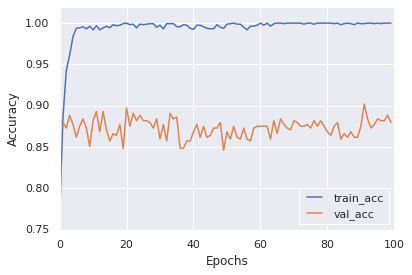

In [98]:
plt.plot(train_acc, label='train_acc')
plt.plot(val_acc, label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim(0.75, 1.02)
plt.savefig(Path('output/accuracy.png'))

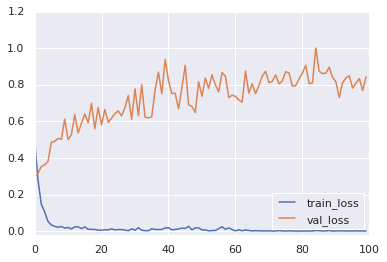

In [100]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='lower right')
plt.ylim(-0.02, 1.2)
plt.savefig(Path('output/loss.png'))

In [90]:
device2 = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model2 = copy.deepcopy(model).to(device2)
# calculate test image accuracy
test_loader = torch.utils.data.DataLoader(
    dataset=TorchDS(test_images, test_labels),
    batch_size=16,
    shuffle=False
)

def test_model(model, dataloaders, criterion, device):
    running_loss = 0
    running_corrects = 0
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders.dataset)
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    return epoch_acc, epoch_loss

test_acc, test_loss = test_model(model2, test_loader, criterion, device2)

Loss: 0.8670 Acc: 0.8778


[11:37:11] Predicted: Smooth, Actual: Smooth                                   ]8;id=836602;file:///tmp/ipykernel_798/231408185.py\231408185.py]8;;\:]8;id=328070;file:///tmp/ipykernel_798/231408185.py#6\6]8;;\

           Correct                                                            ]8;id=430138;file:///tmp/ipykernel_798/231408185.py\231408185.py]8;;\:]8;id=533149;file:///tmp/ipykernel_798/231408185.py#12\12]8;;\

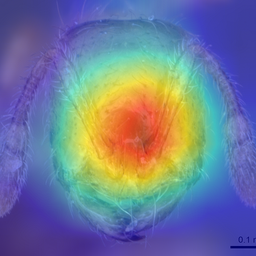

In [122]:
img_no = np.random.randint(0, len(test_images))
image = test_images[img_no]
label = test_labels[img_no]
pred = model(torch.from_numpy(image).unsqueeze(0).to(device)).argmax(dim=1)
label_map = {0: 'Rough', 1: 'Smooth'}
console.log('Predicted: {0}, Actual: {1}'.format(
    label_map[pred.item()],
    label_map[label],
))

if pred.item() == label:
    console.log('Correct', style='green')
else:
    console.log('Incorrect', style='red')

target_layers = [model.layer4[-1]]
input_image = copy.deepcopy(image.astype(np.float32))
input_tensor = torch.from_numpy(input_image).float().unsqueeze(0)

cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(label)]

grayscale_cam = cam(input_tensor, targets)
grayscale_cam = grayscale_cam[0]

visualization = show_cam_on_image(
    input_image.transpose(1, 2, 0) / 255,
    grayscale_cam,
    use_rgb=True,
)

im = Image.fromarray(visualization)
im

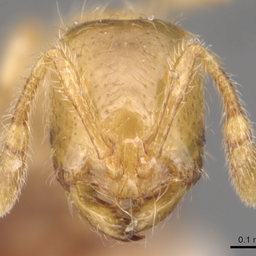

In [123]:
Image.fromarray(image.transpose(1, 2, 0).astype(np.uint8))

In [92]:
im.save(Path('output/gradcam.png'))